In [ ]:
#Don't forget to save your work to your local computer and push to GitHub.
#File -> Download as -> Notebook
#Move file from download folder to local repo clone
#git add filename.ipynb
#git commit -m "put a specific and informative message here of what you worked on"
#git push

# Import and Prepare Dataset - Custom Concept Set for Birth and Preterm Birth 

In this section:  
Import data; rename to long_data (in long format)   
Remove irrelevant values for "condition" (e.g. "second trimester pregnancy" is too vague)    
Convert datetime cells to date only

## Import dataset

In [2]:
import pandas
import pandas as pd
import os
import numpy as np
import time

# This query represents dataset "Concept Set Exploration" for domain "condition" and was generated for All of Us Controlled Tier Dataset v7
dataset_87730747_condition_sql = """
    SELECT
        c_occurrence.person_id,
        c_standard_concept.concept_name as standard_concept_name,
        c_occurrence.condition_start_datetime 
    FROM
        ( SELECT
            * 
        FROM
            `""" + os.environ["WORKSPACE_CDR"] + """.condition_occurrence` c_occurrence 
        WHERE
            (
                condition_concept_id IN  (
                    SELECT
                        DISTINCT c.concept_id 
                    FROM
                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c 
                    JOIN
                        (
                            select
                                cast(cr.id as string) as id 
                            FROM
                                `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr 
                            WHERE
                                concept_id IN (
                                    36712702, 4014295, 432441, 44784550, 45757175, 45757176
                                ) 
                                AND full_text LIKE '%_rank1]%'
                        ) a 
                            ON (
                                c.path LIKE CONCAT('%.',
                            a.id,
                            '.%') 
                            OR c.path LIKE CONCAT('%.',
                            a.id) 
                            OR c.path LIKE CONCAT(a.id,
                            '.%') 
                            OR c.path = a.id) 
                        WHERE
                            is_standard = 1 
                            AND is_selectable = 1
                        )
                )  
                AND (
                    c_occurrence.PERSON_ID IN (
                        SELECT
                            distinct person_id  
                        FROM
                            `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
                        WHERE
                            cb_search_person.person_id IN (
                                SELECT
                                    criteria.person_id 
                                FROM
                                    (SELECT
                                        DISTINCT person_id,
                                        entry_date,
                                        concept_id 
                                    FROM
                                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_all_events` 
                                    WHERE
                                        (
                                            concept_id IN (
                                                SELECT
                                                    DISTINCT c.concept_id 
                                                FROM
                                                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c 
                                                JOIN
                                                    (
                                                        select
                                                            cast(cr.id as string) as id 
                                                        FROM
                                                            `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr 
                                                        WHERE
                                                            concept_id IN (36712702, 45757176, 4014295) 
                                                            AND full_text LIKE '%_rank1]%'
                                                    ) a 
                                                        ON (
                                                            c.path LIKE CONCAT('%.',
                                                        a.id,
                                                        '.%') 
                                                        OR c.path LIKE CONCAT('%.',
                                                        a.id) 
                                                        OR c.path LIKE CONCAT(a.id,
                                                        '.%') 
                                                        OR c.path = a.id) 
                                                    WHERE
                                                        is_standard = 1 
                                                        AND is_selectable = 1
                                                    ) 
                                                    AND is_standard = 1 
                                            )
                                        ) criteria 
                                    ) ))
                        ) c_occurrence 
                    LEFT JOIN
                        `""" + os.environ["WORKSPACE_CDR"] + """.concept` c_standard_concept 
                            ON c_occurrence.condition_concept_id = c_standard_concept.concept_id"""

dataset_87730747_condition_df = pandas.read_gbq(
    dataset_87730747_condition_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_87730747_condition_df.head(5)

Downloading:   0%|          | 0/390805 [00:00<?, ?rows/s]

,person_id,standard_concept_name,condition_start_datetime
0,1669501,"Gestation period, 27 weeks",2016-12-16 00:00:00+00:00
1,1403385,"Gestation period, 27 weeks",2021-09-16 00:00:00+00:00
2,2891121,"Gestation period, 27 weeks",2017-01-23 04:11:46+00:00
3,9309656,"Gestation period, 27 weeks",2021-04-01 07:19:31+00:00
4,3337123,"Gestation period, 27 weeks",2021-12-05 14:24:23+00:00


## Rename dataset
Rename and inspect dataset  
Data in long format (multiple rows per person_id)

In [18]:
raw_birth_data = dataset_87730747_condition_df
print(raw_birth_data.info)
raw_birth_data.sample(3)


<bound method DataFrame.info of         person_id       standard_concept_name  condition_start_datetime
0         1669501  Gestation period, 27 weeks 2016-12-16 00:00:00+00:00
1         1403385  Gestation period, 27 weeks 2021-09-16 00:00:00+00:00
2         2891121  Gestation period, 27 weeks 2017-01-23 04:11:46+00:00
3         9309656  Gestation period, 27 weeks 2021-04-01 07:19:31+00:00
4         3337123  Gestation period, 27 weeks 2021-12-05 14:24:23+00:00
...           ...                         ...                       ...
390800    1430760   Third trimester pregnancy 2019-01-25 11:08:00+00:00
390801    3317844   Third trimester pregnancy 2019-07-30 08:00:00+00:00
390802    2061429   Gestation period, 8 weeks 2019-10-24 14:20:15+00:00
390803    4382057   Third trimester pregnancy 2022-02-09 15:06:00+00:00
390804    2814607   Third trimester pregnancy 2022-03-16 15:04:00+00:00

[390805 rows x 3 columns]>


,person_id,standard_concept_name,condition_start_datetime
357828,1475962,Third trimester pregnancy,2019-12-18 00:00:00+00:00
266003,2691851,Second trimester pregnancy,2020-05-12 17:39:00+00:00
169935,2301625,Single live birth,2003-11-10 05:00:00+00:00


## Drop irrelevant concepts from standard_concept_name

Review values of standard_concept_name and remove irrelevant entries (too vague, not used in analysis, e.g. "gestation less than 20 weeks")

In [19]:
#unique_values = raw_birth_data['standard_concept_name'].unique()

#print("List of all possible values for column 'standard_concept_name':")
#for value in unique_values:
    #print(value)

#Prepare list of values to drop    
values_to_drop = ['Gestation less than 20 weeks', 'Gestation less than 9 weeks']
values_to_drop += ['Finding of length of gestation', 'Gestation less than 24 weeks']
values_to_drop += ['First trimester pregnancy', 'Second trimester pregnancy', 'Third trimester pregnancy']

# Use the 'drop' method to remove rows with specific values in 'standard_concept_name'
raw_birth_data = raw_birth_data[~raw_birth_data['standard_concept_name'].isin(values_to_drop)]

#This filtered df is created by making a boolean list of values_to_drop found in the column 'standard_concept_name'
#The tilde switches this from True to False so that we are applying the opposite of the boolean list to the df
#in order to create the new df


In [21]:
#Convert condition_start_datetime and end_datetime cells to contain only date information and not time, 
#as time is irrelevant to most of our calculations

# Convert the datetime column to a datetime type
raw_birth_data.loc[:,'condition_start_datetime'] = pd.to_datetime(raw_birth_data['condition_start_datetime'])

#Create a new date only column
raw_birth_data.loc[:,'condition_start_date'] = raw_birth_data['condition_start_datetime'].dt.date

#print("New column condition_start_date without time")
raw_birth_data.sample(3)



/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,person_id,standard_concept_name,condition_start_datetime,condition_start_date
35672,2399988,"Gestation period, 37 weeks",2019-04-15 04:00:00+00:00,2019-04-15
194801,5350458,Single live birth,2017-11-15 00:00:00+00:00,2017-11-15
53092,7420331,"Gestation period, 38 weeks",2018-04-03 15:15:00+00:00,2018-04-03


# Remove duplicate entries

Remove duplicates of person_id, birth_concept, and condition_start_date.

In [22]:
birth_concepts = ['Single live birth', 'Preterm spontaneous labor with preterm delivery', 'Term pregnancy', 
                  'Preterm labor in second trimester with preterm delivery in second trimester', 
                  'Preterm labor in third trimester with preterm delivery in third trimester',
                  'Preterm labor with preterm delivery'
                 ]
# Step 1: Create a subset of raw_birth_data where standard_concept_name includes only those values in birth_concepts
subset_birth_concepts = raw_birth_data[raw_birth_data['standard_concept_name'].isin(birth_concepts)]

# Step 2: Remove duplicates that have the same person_id and condition_start_date
subset_birth_concepts_no_duplicates = subset_birth_concepts.drop_duplicates(subset=['person_id', 'condition_start_date'], keep='first')

# Step 3: Recombine df with the subset of raw_birth_data where standard_concept_name includes only those values NOT in birth_concepts
subset_not_birth_concepts = raw_birth_data[~raw_birth_data['standard_concept_name'].isin(birth_concepts)]
combined_data = pd.concat([subset_not_birth_concepts, subset_birth_concepts_no_duplicates], ignore_index=True)

filtered_birth_data = combined_data.copy()

print(filtered_birth_data.info)
filtered_birth_data.sample(20)

<bound method DataFrame.info of         person_id       standard_concept_name  condition_start_datetime  \
0         1669501  Gestation period, 27 weeks 2016-12-16 00:00:00+00:00   
1         1403385  Gestation period, 27 weeks 2021-09-16 00:00:00+00:00   
2         2891121  Gestation period, 27 weeks 2017-01-23 04:11:46+00:00   
3         9309656  Gestation period, 27 weeks 2021-04-01 07:19:31+00:00   
4         3337123  Gestation period, 27 weeks 2021-12-05 14:24:23+00:00   
...           ...                         ...                       ...   
173722    1813744           Single live birth 2018-10-31 05:00:00+00:00   
173723    2079956           Single live birth 2009-06-30 05:00:00+00:00   
173724    3044172           Single live birth 2020-07-17 13:41:00+00:00   
173725    2663433           Single live birth 2009-09-23 05:00:00+00:00   
173726    2553333           Single live birth 2010-08-16 05:00:00+00:00   

       condition_start_date  
0                2016-12-16  
1      

,person_id,standard_concept_name,condition_start_datetime,condition_start_date
76874,4410163,"Gestation period, 19 weeks",2022-05-03 05:00:00+00:00,2022-05-03
116125,1512809,"Gestation period, 39 weeks",2020-01-19 05:00:00+00:00,2020-01-19
149791,1859664,Single live birth,2008-08-06 00:00:00+00:00,2008-08-06
137227,6267494,"Gestation period, 8 weeks",2017-01-25 01:14:21+00:00,2017-01-25
91185,2140028,"Gestation period, 23 weeks",2019-04-02 04:00:00+00:00,2019-04-02
21104,2540905,"Gestation period, 36 weeks",2021-02-02 00:00:00+00:00,2021-02-02
25665,5658363,"Gestation period, 36 weeks",2016-01-25 06:00:00+00:00,2016-01-25
128923,2299059,"Gestation period, 8 weeks",2021-11-05 04:00:00+00:00,2021-11-05
74330,5503907,"Gestation period, 34 weeks",2022-05-05 05:59:59+00:00,2022-05-05
104889,1121036,"Gestation period, 30 weeks",2019-07-04 07:22:00+00:00,2019-07-04


## Explore remaining entries 
- Making sure above filter is working 
- Instances of duplicate person_id and standard_concept_name that differ in condition_start_datetime (how far apart occurring?)
    - Need to discriminate between these and accurate entries after calculating conception and gestational age further in notebook

### View all entries for a specific person_id to explore duplicates of person_id and standard_concept_name

In [27]:
#Resolved
#person_df = filtered_data[filtered_data['person_id'] == 5433458]
#person_df

#RETURN TO THIS PERSON after filtering out those that occur within one week
#person_df = filtered_data[filtered_data['person_id'] == 1302966]
#person_df

#This person resolved - removing birth_concepts on same date effective
#person_df = filtered_birth_data[filtered_birth_data['person_id'] == 1934256	]
#person_df = person_df.sort_values(by='condition_start_date')

#person_df


,person_id,standard_concept_name,condition_start_datetime,condition_start_date
184035,5433458,Single live birth,2022-05-14 00:00:00+00:00,2022-05-14


# Calculate conception date based on observations of gestational length
Use entries of 'standard_concept_name' to calculate date of conception. (ex. Gestation 8 weeks, Gestation 38 weeks).  

In this section:  
- Create a dictionary to view how many times different 'standard_concept_name's are used in the dataset to see which we will need to use for calculations.

- Create a loop to calculate conception date for every instance of 'Gestation period, x weeks' entry in 'standard_concept_name' and populate new column called "conception_date".

- Explore conception date variances / reasons / how to handle discrepancies. 

Note: Through this process I found that because of issues with medical records, our most accurate approach is to start with the most recent medical record of gestation period, e.g. 40 weeks, then look for 39 weeks, and so on. If we start with 8 weeks for example, then we sometimes label a birth as over-term by weeks or months because the instance of 8 week gestation length was for a miscarriage, and then no further records available until the next birth. 


## Create a dictionary to store standard_concept_names and record how often each one is used in df


In [28]:
#view all entries for standard_concept_name

#Create a dictionary to store concept names
concept_dict = {}

#Iterate through column 'standard_concept_name' 
for concept in filtered_birth_data['standard_concept_name']:
    if concept in concept_dict:
        concept_dict[concept] += 1
    else:
        concept_dict[concept] = 1

#print nicely
for key, value in concept_dict.items():
    print(f'{key}: {value}')


Gestation period, 27 weeks: 2563
Gestation period, 26 weeks: 2440
Preterm spontaneous labor with preterm delivery: 503
Gestation period, 16 weeks: 2068
Preterm labor in second trimester with preterm delivery in second trimester: 180
Gestation period, 13 weeks: 2482
Gestation period, 18 weeks: 3506
Gestation period, 14 weeks: 1509
Gestation period, 9 weeks: 39
Gestation period, 35 weeks: 6198
Preterm labor with preterm delivery: 79
Gestation period, 36 weeks: 8688
Gestation period, 11 weeks: 3704
Gestation period, 37 weeks: 9435
Gestation period, 22 weeks: 2541
Gestation period, 10 weeks: 2112
Term pregnancy: 4
Gestation period, 38 weeks: 9384
Gestation period, 40 weeks: 5774
Gestation period, 17 weeks: 1822
Gestation period, 41 weeks: 1333
Gestation period, 12 weeks: 4600
Gestation period, 25 weeks: 2077
Gestation period, 15 weeks: 1493
Gestation period, 34 weeks: 5816
Gestation period, 19 weeks: 3468
Gestation period, 20 weeks: 4013
Gestation period, 21 weeks: 2622
Gestation period, 2

## Create a function to calculate conception date based on standard_concept_name that provides gestational age in weeks.

In [32]:
#Create code to calculate conception date from standard_concept_name that gives gestational age

from datetime import timedelta

# Define a function to calculate the conception date
def calculate_conception(row):
    # Split the 'standard_concept_name' to extract the number of weeks
    concept_name_parts = row['standard_concept_name'].split()
    if len(concept_name_parts) == 4 and concept_name_parts[0] == "Gestation":
        try:
            weeks = int(concept_name_parts[2])
            # Calculate the conception date by subtracting 'weeks' from 'condition_start_datetime'
            conception_date = row['condition_start_date'] - timedelta(weeks=weeks)
            return conception_date
        except ValueError:
            pass
    return None

# Apply the function to create and fill the 'conception_date' column
filtered_birth_data.loc[:,'conception_date'] = filtered_birth_data.apply(calculate_conception, axis=1).copy()

conception_birth_data = filtered_birth_data.copy()

print(conception_birth_data.info)
conception_birth_data.sample(10)



<bound method DataFrame.info of         person_id       standard_concept_name  condition_start_datetime  \
0         1669501  Gestation period, 27 weeks 2016-12-16 00:00:00+00:00   
1         1403385  Gestation period, 27 weeks 2021-09-16 00:00:00+00:00   
2         2891121  Gestation period, 27 weeks 2017-01-23 04:11:46+00:00   
3         9309656  Gestation period, 27 weeks 2021-04-01 07:19:31+00:00   
4         3337123  Gestation period, 27 weeks 2021-12-05 14:24:23+00:00   
...           ...                         ...                       ...   
173722    1813744           Single live birth 2018-10-31 05:00:00+00:00   
173723    2079956           Single live birth 2009-06-30 05:00:00+00:00   
173724    3044172           Single live birth 2020-07-17 13:41:00+00:00   
173725    2663433           Single live birth 2009-09-23 05:00:00+00:00   
173726    2553333           Single live birth 2010-08-16 05:00:00+00:00   

       condition_start_date conception_date  
0                2016

,person_id,standard_concept_name,condition_start_datetime,condition_start_date,conception_date
166357,1433685,Single live birth,2021-03-25 09:17:23+00:00,2021-03-25,None
99114,2718591,"Gestation period, 32 weeks",2016-06-24 12:05:00+00:00,2016-06-24,2015-11-13
18196,2857488,"Gestation period, 35 weeks",2019-04-23 05:00:00+00:00,2019-04-23,2018-08-21
47379,1276227,"Gestation period, 38 weeks",2020-01-20 17:39:00.100000+00:00,2020-01-20,2019-04-29
79355,2797403,"Gestation period, 34 weeks",2018-09-17 16:45:00+00:00,2018-09-17,2018-01-22
58269,1148219,"Gestation period, 40 weeks",2019-07-24 05:00:00+00:00,2019-07-24,2018-10-17
152494,1656765,Single live birth,2019-01-02 18:23:00.957000+00:00,2019-01-02,None
118200,2759849,"Gestation period, 39 weeks",2019-06-22 23:15:42+00:00,2019-06-22,2018-09-22
151108,2882901,Single live birth,2017-06-14 05:00:00+00:00,2017-06-14,None
64271,2059743,"Gestation period, 41 weeks",2016-07-22 00:00:00+00:00,2016-07-22,2015-10-09


## Example of a person with inconsistent conception dates

Example: After calculating gestational age at birth, let's check that person 5433458 above has a birth that is correctly labeled as 40 weeks. (Need to view after running code below to calculate gestational age at birth; conception date not calculated for birth concepts.)
RETURN TO PERSON
Uncomment to view

## TO DO Resolving conception dates that conflict  

### Conception dates may be inconsistent.

Some reasons include:
- Error in records
- Prenatal appointments are labeled by the week but can occur at the beginning or end of the week (so can be up to 7 days apart)
- Occasionally gestational ages are updated at early ultrasound appointments 

Notes in the literature:
- Early ultrasounds are much better at predicting gestational age (8-13 weeks, but the earlier the better) ( American College of Obstetricians and Gynecologists)
- Most first prenatal appointments are scheduled at 8 weeks or after

### Calculate conception date based on most recent entry of gestation period

After going through our data, I feel that our best calculations will be based on gestation length starting with the longest first, as we know that the gestation was **at least** that long, making our preterm births true preterm, versus the possibility of labeling some preterm  births as term when they are not based on "8 week ultrasound appointments" which may or may not actually be exactly at 8 weeks. 

### How conflicts can be handled in the code:
- If the conflict occurs in a gestational week that is earlier than the gestational week that co-occurs with birth, it will not be used to calculate gestational age at birth.
- If the conflict occurs in the gestational week at the same week as the birth, then our code below takes the date from the first instance. This might not be accurate, so we need to find a way to intelligently choose the correct instance.
- One way to accomplish this is to check that the calculation of (date of Single live birth - conception date) is within 7 days of the "gestation period x weeks" of the same row as conception date. You'd need to split the phrase and pull out the number in weeks and then compare that number to the gestational age at birth calculation. 


# Calculate Gestational Age

In this section:

Calculate Gestational Age
- Sort by person_id, condition_start_date, and then standard_concept_name. Sorting by the latter will make sure that for the same date, all Gestational period entries will occur before the birth entry. 

- Calculate gestational_age_at_birth by subtracting condition_start_time for "Single live birth" from conception_date from measurements most accurate for determining minimum gestation length (e.g. 42 weeks, then 41, 40, etc).     

Explore entries
- Exploration of person_ids that have gestational ages that are unreasonably high (above 42 weeks) or low (less than 8 weeks and negaative entries, indicating that conception date was pulled from another person or another pregnancy. 


## Calculate gestational age at birth for instances of birth concepts

(condition_start_date for birth concept - conception_date)


In [33]:
#Apply loop to calculate gestional_age_at_birth to birth concepts that have gestational data available.
conception_copy = conception_birth_data.copy()

# Start measuring execution time
start_time = time.time()

# Sort the DataFrame by person_id and condition_start_date
conception_copy = conception_copy.sort_values(by=['person_id', 'condition_start_date', 'standard_concept_name', 'condition_start_datetime'])

birth_concepts = ['Single live birth', 'Preterm spontaneous labor with preterm delivery', 'Term pregnancy', 
                  'Preterm labor in second trimester with preterm delivery in second trimester', 
                  'Preterm labor in third trimester with preterm delivery in third trimester',
                  'Preterm labor with preterm delivery'
                 ]

for concept in birth_concepts:
    # Initialize a dictionary to store the most recent "Gestation period" and conception date for each person_id
    gestational_info = {}

    # Initialize a list to store birth dates
    birth_dates = []

    # Iterate through the DataFrame
    for idx, row in conception_copy.iterrows():
        person_id = row['person_id']

        if person_id not in gestational_info:
            gestational_info[person_id] = {'gestational_period': None, 'conception_date': None}

        current_gestational_period = gestational_info[person_id]['gestational_period']
        conception_date = gestational_info[person_id]['conception_date']

        if row['standard_concept_name'].startswith('Gestation period'):
            # Update the current gestational period
            gestational_info[person_id]['gestational_period'] = row['standard_concept_name']
            gestational_info[person_id]['conception_date'] = row['conception_date']

        if row['standard_concept_name'] == concept:
            if conception_date is not None:
                birth_dates.append((idx, row['condition_start_date']))
                last_idx, last_birth_date = birth_dates[-1]
                gestational_age = (pd.to_datetime(last_birth_date) - pd.to_datetime(conception_date)).days / 7
                conception_copy.at[last_idx, 'gestational_age_at_birth'] = gestational_age
                conception_date = None


# End measuring execution time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time} seconds")

# Display a sample of the updated DataFrame
gestational_age_data = conception_copy.copy()
gestational_age_data.sample(10)

Execution time: 103.17040753364563 seconds


,person_id,standard_concept_name,condition_start_datetime,condition_start_date,conception_date,gestational_age_at_birth
104743,2682222,"Gestation period, 30 weeks",2016-12-09 15:52:22+00:00,2016-12-09,2016-05-13,NaN
124422,1605748,"Gestation period, 33 weeks",2019-05-15 05:59:59+00:00,2019-05-15,2018-09-26,NaN
32393,1792889,"Gestation period, 11 weeks",2021-11-22 05:00:00+00:00,2021-11-22,2021-09-06,NaN
76232,1084380,"Gestation period, 34 weeks",2020-05-26 05:59:59+00:00,2020-05-26,2019-10-01,NaN
107270,5250713,"Gestation period, 28 weeks",2021-09-08 05:59:59+00:00,2021-09-08,2021-02-24,NaN
127420,3082040,"Gestation period, 33 weeks",2015-12-17 00:00:00+00:00,2015-12-17,2015-04-30,NaN
111026,3016021,"Gestation period, 39 weeks",2019-06-15 13:40:00.100000+00:00,2019-06-15,2018-09-15,NaN
93517,1894876,"Gestation period, 29 weeks",2018-05-15 04:00:00+00:00,2018-05-15,2017-10-24,NaN
3092,2014780,"Gestation period, 26 weeks",2020-03-10 15:33:07+00:00,2020-03-10,2019-09-10,NaN
94333,3341615,"Gestation period, 29 weeks",2021-06-15 18:11:52+00:00,2021-06-15,2020-11-24,NaN


### Gestational Age Min/Max and Number of Entries Added

In [34]:
# Calculate min and max values of 'gestational_age_at_birth'
min_value = gestational_age_data['gestational_age_at_birth'].min()
max_value = gestational_age_data['gestational_age_at_birth'].max()

print(f"Range of gestational_age_at_birth: {min_value} to {max_value}")

# Calculate number of gestational ages added
added_gestational_ages = gestational_age_data['gestational_age_at_birth'].count()
print("Number of gestational ages added:", added_gestational_ages)

# Remove gestational age == na 
removed_entries_count = len(gestational_age_data)

for concept in birth_concepts:
    gestational_age_data = gestational_age_data[~((gestational_age_data['standard_concept_name'] == concept) & gestational_age_data['gestational_age_at_birth'].isna())]

removed_entries_count -= len(gestational_age_data)

print(f"{removed_entries_count} n/a entries were removed from the column gestational age at birth.")

Range of gestational_age_at_birth: 8.0 to 320.2857142857143
Number of gestational ages added: 21533
14583 n/a entries were removed from the column gestational age at birth.


## Explore person_ids to find out why we might have neg, overterm, missing entries.

These cells are can be uncommented if you wish to view the entries used for exploration/troubleshooting.
- Gestational length longer than 42 weeks examined for legitimacy. Cutoff chosen to be < 45 weeks based on dataset for truly overdue babies.
- In literature, generally pregnancies are induced if longer than 41 weeks. 
- Overdue is considered > 42 weeks.
- No neg entries found once code improved.
- Missing entries due to lack of medical history. 


In [ ]:
# Filter the dataframe to select rows with "Single live birth" and terms to explore (e.g. why neg ages, why over-term etc)
#explore_gestational_age_df = df_copy[(df_copy['standard_concept_name'] == 'Single live birth') & (df_copy['gestational_age_at_birth'] > 42)]

# Get the unique person_id values for those rows
#person_ids_with_expl_values = explore_gestational_age_df['person_id'].unique()

# Display the list of person_id values
#print("person_id values with explore gestational ages in 'Single live birth' entries:")
#print(person_ids_with_expl_values)

#explore_gestational_age_df

In [ ]:
#There are four records with believable gestational ages. Let's look at their entire record. They appear to be legitimate, so
#will keep maximum gestation filter at < 45 weeks, which captures all of these births. The next longest gestational age in our
#dataset is 69 weeks. 

#person_check = df_copy[df_copy['person_id'] == 1001034]
#person_check

#person_check = df_copy[df_copy['person_id'] == 2275959]
#person_check

#person_check = df_copy[df_copy['person_id'] == 2455910]
#person_check

#person_check = df_copy[df_copy['person_id'] == 2914516]
#person_check


In [ ]:
#Uncomment lines below if you wish to view some of the records used in troubleshooting.

#person_check = date_only_long_data_no_triple_duplicates[date_only_long_data_no_triple_duplicates['person_id'] == 1001034]
#person_check

#person resolved; gestation periods not prioritizing correctly
#person_df = df[df['person_id'] == 1001034]
#person_df

#person resolved; using 8 week measurement from probable pregnancy loss
#person_df = df[df['person_id'] == 9930591]
#person_df

#person resolved; very long gestation are because there are no entries for prenatal care / unknown term length. 
#Data was being pulled from previous pregnancy without subsequent birth record.
#person_df = df_copy[df_copy['person_id'] == 3892859]
#person_df
#person_df = df_copy[df_copy['person_id'] == 1895079]
#person_df

#Person with legitimate 42.7 week pregnancy (also previous history of long term, 41 weeks)
#person_df = df_copy[df_copy['person_id'] == 2455910]
#person_df



#### Explore missing gestational age for birth concepts - use before dropping missing entries if you wish to see #s

Last output: 
Single live birth Missing gestational age entries 14467  
Preterm spontaneous labor with preterm delivery Missing gestational age entries 121  
Term pregnancy Missing gestational age entries 0  
Preterm labor in second trimester with preterm delivery in second trimester Missing gestational age entries 5  
Preterm labor in third trimester with preterm delivery in third trimester Missing gestational age entries 13  
Preterm labor with preterm delivery Missing gestational age entries 4  

In [ ]:
'''
for concept in birth_concepts:
    missing_gestational_age = gestational_age_data[gestational_age_data['standard_concept_name'] == concept][gestational_age_data['gestational_age_at_birth'].isna()]
    print(concept, "missing gestational age entries", len(missing_gestational_age))

#person_df = df_copy[df_copy['person_id'] == 1060177]
#person_df

#person_df = df_copy[df_copy['person_id'] == 1533076]
#person_df

#person_df = df_copy[df_copy['person_id'] == 1932809]
#person_df
'''

In [ ]:
#person_df2 = gestational_age_data[gestational_age_data['person_id'] == 5433458	]
#person_df2 = person_df2.sort_values(by='condition_start_date')
#person_df2

## Calculate the mode of conception dates for a given person_id and birth - needs work


In [ ]:
'''
## Calculate the mode of conception dates for a given person_id and birth - needs work
person_df = date_only_long_data_no_triple_duplicates[date_only_long_data_no_triple_duplicates['person_id'] == 5433458]
person_df = person_df.sort_values(by='condition_start_date')

person_df


person_df['conception_date'] = pd.to_datetime(person_df['conception_date'], format='%Y-%m-%d')
data_type = person_df['conception_date'].dtypes
print(f"Data type of 'conception_date' column after conversion: {data_type}")


person_df['rounded_datetime'] = person_df['conception_date'].dt.floor('D')


mode_date = df_copy['conception_date'].mode()
if not mode_date.empty:
    print(f"Mode Datetime: {mode_date.iloc[0]}")
else:
    print("No mode value found in the 'conception_date' column.")


# Calculate the mode of the rounded datetime
mode_date = person_df['rounded_datetime'].mode()


# Print the mode datetime
print(f"Mode Datetime: {mode_date.iloc[0]}")


# Assuming you have a DataFrame with a datetime column named 'datetime_column'
median_date = person_df['conception_date'].median()

# Print the median date
print(f"Median Date: {median_date}")


#mean = person_df['conception_date'].mean()
#med = person_df['conception_date'].median()
#mode = person_df['conception_date'].mode()

#print("mean:", mean, "median:", med, "mode:", mode)

#person_df.dropna(subset=['conception_date'])
'''

## Dataset observations (also, remove gestational ages less than 22 and more than 45 weeks)

In [35]:
#Checking numbers to see how the loop is working. 

#Missing gestation_age_at_birth (for example, birth occurred but no previous records attached)
birth_concepts = ['Single live birth', 'Preterm spontaneous labor with preterm delivery', 'Term pregnancy', 
                  'Preterm labor in second trimester with preterm delivery in second trimester', 
                  'Preterm labor in third trimester with preterm delivery in third trimester',
                  'Preterm labor with preterm delivery'
                 ]

negative_gestational_age = len(gestational_age_data[gestational_age_data['gestational_age_at_birth'] < 0])
greater_than_45_weeks = len(gestational_age_data[gestational_age_data['gestational_age_at_birth'] > 45])
lessthan22_gestational_age = len(gestational_age_data[gestational_age_data['gestational_age_at_birth'] < 22])

#Filter the DataFrame for gestational ages at birth between 22 and <=45 weeks
filtered_df_copy = gestational_age_data[(gestational_age_data['gestational_age_at_birth'] >= 22) & (gestational_age_data['gestational_age_at_birth'] <= 45)]

births_full_term = len(filtered_df_copy[(filtered_df_copy['gestational_age_at_birth'] >= 37)])
births_under_37_weeks = len(filtered_df_copy[(filtered_df_copy['gestational_age_at_birth'] < 37)])
births_late_preterm = len(filtered_df_copy[(filtered_df_copy['gestational_age_at_birth'] >= 32) & (filtered_df_copy['gestational_age_at_birth'] < 37)])
births_very_preterm = len(filtered_df_copy[(filtered_df_copy['gestational_age_at_birth'] >= 28) & (filtered_df_copy['gestational_age_at_birth'] < 32)])
births_extremely_preterm = len(filtered_df_copy[(filtered_df_copy['gestational_age_at_birth'] < 28)])

number_unique_ids = len(filtered_df_copy['person_id'].unique())

# Display the counts of entries deleted
print("Number of entries with negative gestational age deleted:", negative_gestational_age)
print("Number of entries with gestational age greater than 45 weeks deleted:", greater_than_45_weeks)
print("Number of entries with gestational age less than 22 weeks deleted", lessthan22_gestational_age)
print("Number of births that are full term >= 37 weeks:", births_full_term)
print("Number of births that are any class of Preterm:", births_under_37_weeks)
print("Number of births that are Late Preterm >= 32 and < 37 weeks:", births_late_preterm)
print("Number of births that are Very Preterm >= 28 weeks and < 32 weeks:", births_very_preterm)
print("Number of births that are Extremely Preterm < 28 weeks:", births_extremely_preterm)
print("Total number of births:", (births_full_term + births_under_37_weeks))
print("Percentage of births that are any class of preterm:", births_under_37_weeks / (births_full_term + births_under_37_weeks)  * 100)
print("Number of unique person_ids:", number_unique_ids)

min_gestational_age = filtered_df_copy['gestational_age_at_birth'].min()
print(f"The minimum gestational age at birth in this dataset is: {min_gestational_age} weeks")

max_gestational_age = filtered_df_copy['gestational_age_at_birth'].max()
print(f"The max gestational age at birth in this dataset is: {max_gestational_age} weeks")

gestational_age_data = filtered_df_copy.copy()

Number of entries with negative gestational age deleted: 0
Number of entries with gestational age greater than 45 weeks deleted: 79
Number of entries with gestational age less than 22 weeks deleted 142
Number of births that are full term >= 37 weeks: 18309
Number of births that are any class of Preterm: 3003
Number of births that are Late Preterm >= 32 and < 37 weeks: 2342
Number of births that are Very Preterm >= 28 weeks and < 32 weeks: 423
Number of births that are Extremely Preterm < 28 weeks: 238
Total number of births: 21312
Percentage of births that are any class of preterm: 14.090653153153154
Number of unique person_ids: 11959
The minimum gestational age at birth in this dataset is: 22.0 weeks
The max gestational age at birth in this dataset is: 44.142857142857146 weeks


# Rexamine 'duplicate' entries

- Same person_id, Births, Occurring within a certain time frame of each other --> delete those within one week 
- Challenge is for births that occur a few weeks or even months apart, how to determine which one is "accurate" especially when gestational lengths don't make a lot of sense.

## TO DO: Remove births that occur too close together

Exploration of nonsensical data:  
- Ex.  does this person have single live birth occurring 10 weeks after another birth, but it is a term birth? 
- We need to screen and delete births that occur after another birth, but the term length of the birth is longer than the time in between births. see example 1006417 and 8911365


In [97]:
#Person resolved by removing entries closer than 154 days (22 weeks)
person_df = final_birth_data[final_birth_data['person_id'] == 1006417]
person_df


#Person resolved by removing entries closer than 154 days (22 weeks)
#person_df = gestational_age_data[gestational_age_data['person_id'] == 8911365]
#person_df

#person_df = final_birth_data[final_birth_data['person_id'] == 8911365] 
#person_df


,person_id,condition_start_date,birth_class,gestational_age_at_birth,birth_order
42,1006417,2019-10-16,Term,41.285714,1


# Classify births into term or preterm class based on gestational age at birth

Term >= 37 weeks  
37 weeks > Preterm >= 22 weeks

In [41]:
gestational_age_data = filtered_df_copy.copy()

In [64]:
# Create a new column "birth_class" and set it to 'Unknown' initially
gestational_age_data['birth_class'] = 'Unknown'

# Fill in the birth class column based on gestational age at birth.
gestational_age_data.loc[(gestational_age_data['gestational_age_at_birth'] >= 37), 'birth_class'] = 'Term'
gestational_age_data.loc[(gestational_age_data['gestational_age_at_birth'] >= 22) & (gestational_age_data['gestational_age_at_birth'] < 37), 'birth_class'] = 'Preterm'

#Remove all lines that contain birth class == Unknown (e.g. remove gestational findings, etc)
birth_class_data = gestational_age_data[gestational_age_data['birth_class'] != 'Unknown']

print(len(birth_class_data))

birth_class_data.sample(10)

21312


,person_id,standard_concept_name,condition_start_datetime,condition_start_date,conception_date,gestational_age_at_birth,birth_class
147852,1281759,Single live birth,2019-12-04 13:26:35+00:00,2019-12-04,None,39.0,Term
148741,1078086,Single live birth,2019-11-26 05:00:00+00:00,2019-11-26,None,38.0,Term
152084,3459482,Single live birth,2022-02-20 14:51:00+00:00,2022-02-20,None,40.0,Term
137783,1230906,Preterm spontaneous labor with preterm delivery,2020-10-23 05:00:00+00:00,2020-10-23,None,32.0,Preterm
142486,1325000,Single live birth,2016-02-07 00:50:00+00:00,2016-02-07,None,39.0,Term
148651,1320833,Single live birth,2021-03-18 09:09:24+00:00,2021-03-18,None,38.0,Term
149451,3269355,Single live birth,2019-09-15 04:00:00+00:00,2019-09-15,None,39.0,Term
137691,2773603,Preterm spontaneous labor with preterm delivery,2019-08-12 16:01:00.101000+00:00,2019-08-12,None,32.0,Preterm
170144,1421760,Single live birth,2018-03-18 15:42:00+00:00,2018-03-18,None,39.0,Term
155187,3251528,Single live birth,2019-05-29 04:00:00+00:00,2019-05-29,None,37.0,Term


In [ ]:
'''
CLASSIFICATION INTO FOUR GROUPS
Keeping code in case we want to try this later

### Classify birth as term, late preterm, very preterm, and extremely preterm using gestational_age_at_birth

This classifies all instances of concept (Single live birth, preterm birth, etc) that have a valid gestational age  

Term >= 37 weeks  
37 weeks > Late Preterm >= 32 weeks  
32 weeks > Very Preterm >=28 weeks  
28 weeks > Extremely Preterm  
# Create a new column "birth_class" and set it to 'Unknown' initially
filtered_df_copy['birth_class'] = 'Unknown'

#Once we have also addressed standard_concept_name containing preterm birth, then we can delete all rows
#with birth_class "Unknown". This will give us a long format data set (x rows and columns person_id, condition_start_date,
#and birth_class)

filtered_df_copy.loc[(filtered_df_copy['gestational_age_at_birth'] >= 37), 'birth_class'] = 'Term'
filtered_df_copy.loc[(filtered_df_copy['gestational_age_at_birth'] >= 32) & (filtered_df_copy['gestational_age_at_birth'] < 37), 'birth_class'] = 'Late Preterm'
filtered_df_copy.loc[(filtered_df_copy['gestational_age_at_birth'] >= 28) & (filtered_df_copy['gestational_age_at_birth'] < 32), 'birth_class'] = 'Very Preterm'
filtered_df_copy.loc[filtered_df_copy['gestational_age_at_birth'] < 28, 'birth_class'] = 'Extremely Preterm'


df_class_copy = filtered_df_copy[filtered_df_copy['standard_concept_name'].str.contains('birth|delivery|term', case=False)]
df_class_copy.sample(10)
'''

# Basic Stats and Visualizations

Basic visualizations to check that the data cleaning looks reasonable.

## Distribution of all births

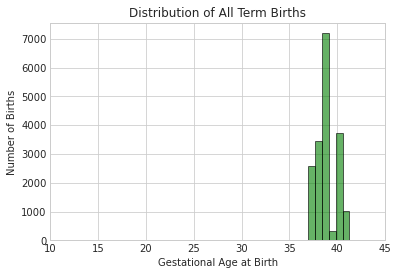

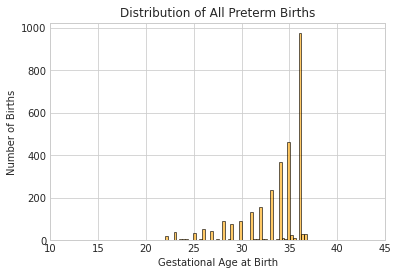

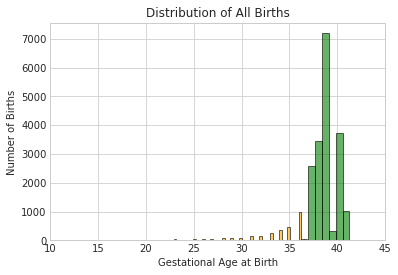

In [43]:
import matplotlib.pyplot as plt

# All Term Births
plt.style.use("seaborn-whitegrid")
term_cases = birth_class_data[birth_class_data['birth_class'] == 'Term']
plt.hist(term_cases['gestational_age_at_birth'], bins=10, alpha=0.6, color='green', edgecolor='black', label='All Term')
plt.xlabel('Gestational Age at Birth')
plt.ylabel('Number of Births')
plt.title('Distribution of All Term Births')
plt.xlim(10, 45) 
plt.show()


# All Preterm Births
non_term_cases = birth_class_data[birth_class_data['birth_class'] != 'Term']
plt.style.use("seaborn-whitegrid")
plt.hist(non_term_cases['gestational_age_at_birth'], bins=50, alpha=0.6, color='orange', edgecolor='black', label='All Preterm')
plt.xlabel('Gestational Age at Birth')
plt.ylabel('Number of Births')
plt.title('Distribution of All Preterm Births')
plt.xlim(10, 45) 
plt.show()


#All Births
plt.style.use("seaborn-whitegrid")
plt.hist(term_cases['gestational_age_at_birth'], bins=10, alpha=0.6, color='green', edgecolor='black', label='All Term')
plt.hist(non_term_cases['gestational_age_at_birth'], bins=50, alpha=0.6, color='orange', edgecolor='black', label='All Preterm')
plt.xlabel('Gestational Age at Birth')
plt.ylabel('Number of Births')
plt.title('Distribution of All Births')
plt.xlim(10, 45) 
plt.show()



## Basic Descriptive Statistics

In [44]:
# Create categories and a dictionary to store statistics for each category
categories = ['Term', 'Preterm']
category_stats = {}

# Calculate and store statistics for each category
for category in categories:
    category_data = birth_class_data[birth_class_data['birth_class'] == category]
    if not category_data.empty:
        category_stats[category] = category_data.describe()

# Display the statistics for each category
for category, stats in category_stats.items():
    print(f"Statistics for {category}:")
    print(stats)
    print()


Statistics for Term:
          person_id  gestational_age_at_birth
count  1.830900e+04              18309.000000
mean   2.824374e+06                 38.861700
std    1.994422e+06                  1.090376
min    1.000131e+06                 37.000000
25%    1.549499e+06                 38.000000
50%    2.130583e+06                 39.000000
75%    3.143503e+06                 40.000000
max    9.998770e+06                 44.142857

Statistics for Preterm:
          person_id  gestational_age_at_birth
count  3.003000e+03               3003.000000
mean   2.760948e+06                 33.370867
std    1.906316e+06                  3.308945
min    1.001034e+06                 22.000000
25%    1.551562e+06                 32.000000
50%    2.129101e+06                 35.000000
75%    3.107623e+06                 36.000000
max    9.989602e+06                 36.857143



In [ ]:
'''
##33 entries found. We can delete these.??
## Check Preterm birth entries categorization

Double check - entries containing "preterm" from standard_concept_name should be categorized as a class of Preterm in column birth_class by our calculations.
preterm_rows = filtered_df_copy[filtered_df_copy['standard_concept_name'].str.contains('Preterm')]
print("Number of births derived from standard_concept_name containing Preterm:", len(preterm_rows))

#Make a df of rows that have preterm in concept name but NOT preterm birth classification in birth_class
preterm_check_df = filtered_df_copy[filtered_df_copy['standard_concept_name'].str.contains(r'\bPreterm\b') & ~filtered_df_copy['birth_class'].str.contains(r'\bPreterm\b')]
print("Number of rows that have preterm in birth concept name but not preterm classification by our code:", len(preterm_check_df))

#Remove those accurately classified as preterm (< 37 weeks) according to our calculations
preterm_check_df1 = preterm_check_df.drop(preterm_check_df[preterm_check_df['gestational_age_at_birth'] < 37].index)
print("Number of rows remaining after removing those correctly classified as preterm:", len(preterm_check_df1))

#Remove rows with birth class unknown
preterm_check_df2 = preterm_check_df1.drop(preterm_check_df1[preterm_check_df1['birth_class'] == "Unknown"].index)
print("Number of rows remaining after removing those with birth class Unknown:", len(preterm_check_df2))

preterm_check_df3 = preterm_check_df2.drop(preterm_check_df2[preterm_check_df2['gestational_age_at_birth'] > 45].index)
print("Entries with conflict between 'preterm' birth concept and birth_class <= 45 weeks of age", len(preterm_check_df3))

print("Unique entries of gestational ages at birth between 37 and 45 weeks", preterm_check_df3['gestational_age_at_birth'].unique())


#filtered_df_copy.sample(20)
'''


## When classification is mismatched with birth concept entry, we will use classification. When there is a medical entry error, we can try to catch by using mode of conception (?)TO DO: 


In instances where our calculations were gestational age indicating a term birth, but the birth concept entry was a form of "preterm birth", we will keep the data classifed as we calculated (term birth). This is consistent with the way we have treated the data e.g. calculating gestational age at birth based on records provided indicating gestational period at previous health appointments. 

In cases where one of the medical records was an error, see below, perhaps mode of conception date can help catch these...

# Prepare data for model 

## Keep only relevant columns

In [80]:
selected_columns = ["person_id", "condition_start_date", "birth_class", "gestational_age_at_birth"]
filtered_birth_data = birth_class_data[selected_columns]

filtered_birth_data.info


<bound method DataFrame.info of         person_id condition_start_date birth_class  gestational_age_at_birth
145673    1000131           2021-09-22        Term                      39.0
156692    1000195           2021-08-10        Term                      40.0
150387    1000195           2021-08-11        Term                      41.0
169966    1000724           2019-08-06        Term                      40.0
168650    1001000           2018-11-09        Term                      40.0
...           ...                  ...         ...                       ...
146375    9989602           2017-01-14        Term                      37.0
156406    9989602           2017-12-23        Term                      38.0
144922    9989602           2021-03-16     Preterm                      36.0
164342    9998770           2016-10-25        Term                      39.0
160496    9998770           2022-05-05        Term                      38.0

[21312 rows x 4 columns]>

## Remove births that occur on the same date for a given person_id

In [83]:
starting_count = len(filtered_birth_data)
print("Number of births before removing duplicates", starting_count)

# Mark duplicates based on 'person_id' and 'condition_start_date' and keep the first entry
filtered_birth_data['is_duplicate'] = filtered_birth_data.duplicated(subset=['person_id', 'condition_start_date'], keep='first')

# Keep only the rows where 'is_duplicate' is False (i.e., keep the first entry of each group)
filtered_birth_data = filtered_birth_data[~filtered_birth_data['is_duplicate']]

# Drop the 'is_duplicate' column if you don't need it anymore
filtered_birth_data = filtered_birth_data.drop(columns=['is_duplicate'])

# Reset the index of the resulting DataFrame
filtered_birth_data = filtered_birth_data.reset_index(drop=True)

final_count = len(filtered_birth_data)
print("Number of duplicate births removed", starting_count-final_count)
print("Number of births after removing duplicates", final_count)

filtered_birth_data.sample(10)

Number of births before removing duplicates 21312
Number of duplicate births removed 0
Number of births after removing duplicates 21312


,person_id,condition_start_date,birth_class,gestational_age_at_birth
6544,1678744,2019-01-23,Term,40.0
14289,2821798,2019-08-07,Term,39.0
5229,1536777,2020-05-12,Preterm,36.0
11161,2215521,2020-11-28,Term,39.0
15679,3079338,2016-09-12,Term,39.0
12281,2442260,2016-05-17,Term,38.0
5497,1567324,2018-05-10,Term,39.0
19491,6437309,2022-04-06,Term,37.0
15973,3138648,2019-01-12,Term,39.0
1546,1155859,2019-12-23,Term,40.0


## Now remove those that occur within 154 days (22 weeks) of each other

In [88]:
# Convert 'condition_start_date' to datetime format
filtered_birth_data['condition_start_date'] = pd.to_datetime(filtered_birth_data['condition_start_date'])

# Sort by 'person_id' and 'condition_start_date'
filtered_birth_data = filtered_birth_data.sort_values(['person_id', 'condition_start_date'])

# Calculate the time difference within each 'person_id' group
filtered_birth_data['time_diff'] = filtered_birth_data.groupby(['person_id'])['condition_start_date'].diff()

# Create a mask for entries where time_diff is null or greater than 1 day
mask_keep = (filtered_birth_data['time_diff'].isnull()) | (filtered_birth_data['time_diff'].dt.days > 154)

# Count the number of entries before filtering
entries_before = len(filtered_birth_data)

# Keep only the rows where the mask is True
filtered_birth_data = filtered_birth_data[mask_keep]

# Count the number of entries after filtering
entries_after = len(filtered_birth_data)

# Print the number of entries removed and kept
entries_removed = entries_before - entries_after
print(f"Entries removed: {entries_removed}")
print(f"Entries kept: {entries_after}")

# Drop the additional columns if you don't need them anymore
filtered_birth_data = filtered_birth_data.drop(columns=['time_diff'])

# Reset the index of the resulting DataFrame
filtered_birth_data = filtered_birth_data.reset_index(drop=True)

filtered_birth_data.sample(10)


Entries removed: 0
Entries kept: 15601


,person_id,condition_start_date,birth_class,gestational_age_at_birth
4321,1624764,2017-12-05,Term,38.0
4711,1685388,2020-10-07,Term,39.0
13370,5119092,2018-07-10,Term,39.0
14313,7125916,2022-05-02,Preterm,34.0
1964,1279903,2019-02-04,Term,38.0
8345,2343941,2017-01-27,Preterm,27.0
1585,1225741,2016-09-16,Term,39.0
6722,1987234,2019-10-01,Term,39.0
7367,2086878,2016-07-12,Term,40.0
14980,8593376,2019-05-11,Term,40.0


### Engineer feature that keeps track of birth order

In [89]:
#Sort by person_id and condition_start_date
final_birth_data = filtered_birth_data.sort_values(by=["person_id", "condition_start_date"])

# Calculate birth_order
final_birth_data["birth_order"] = final_birth_data.groupby("person_id").cumcount() + 1

final_birth_data.head(20)
final_birth_data.info

<bound method DataFrame.info of        person_id condition_start_date birth_class  gestational_age_at_birth  \
0        1000131           2021-09-22        Term                      39.0   
1        1000195           2021-08-10        Term                      40.0   
2        1000724           2019-08-06        Term                      40.0   
3        1001000           2018-11-09        Term                      40.0   
4        1001034           2017-06-28        Term                      39.0   
...          ...                  ...         ...                       ...   
15596    9989602           2017-01-14        Term                      37.0   
15597    9989602           2017-12-23        Term                      38.0   
15598    9989602           2021-03-16     Preterm                      36.0   
15599    9998770           2016-10-25        Term                      39.0   
15600    9998770           2022-05-05        Term                      38.0   

       birth_order 

In [90]:
# Create categories and a dictionary to store statistics for each category
categories = ['Term', 'Preterm']
category_stats = {}

# Calculate and store statistics for each category
for category in categories:
    category_data = final_birth_data[final_birth_data['birth_class'] == category]
    if not category_data.empty:
        category_stats[category] = category_data.describe()

# Display the statistics for each category
for category, stats in category_stats.items():
    print(f"Statistics for {category}:")
    print(stats)
    print()
    

Statistics for Term:
          person_id  gestational_age_at_birth   birth_order
count  1.343400e+04              13434.000000  13434.000000
mean   2.958510e+06                 38.841638      1.276165
std    2.116125e+06                  1.067879      0.530288
min    1.000131e+06                 37.000000      1.000000
25%    1.565325e+06                 38.000000      1.000000
50%    2.200748e+06                 39.000000      1.000000
75%    3.260879e+06                 40.000000      1.000000
max    9.998770e+06                 44.000000      5.000000

Statistics for Preterm:
          person_id  gestational_age_at_birth  birth_order
count  2.167000e+03               2167.000000  2167.000000
mean   2.857171e+06                 33.389149     1.228426
std    2.002075e+06                  3.381602     0.488997
min    1.001034e+06                 22.000000     1.000000
25%    1.559583e+06                 32.000000     1.000000
50%    2.174813e+06                 35.000000     1.000000
7

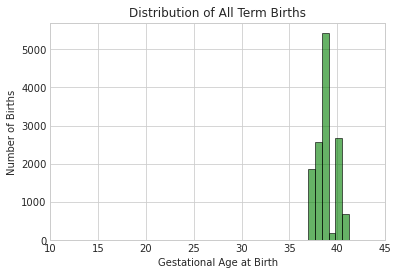

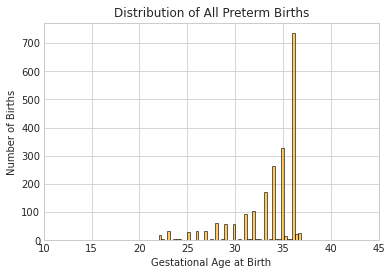

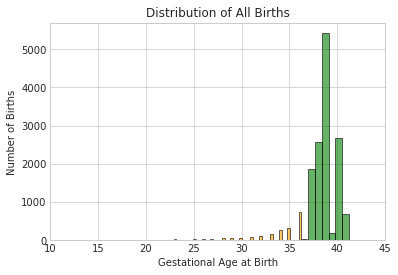

In [91]:
import matplotlib.pyplot as plt

# All Term Births
plt.style.use("seaborn-whitegrid")
term_cases = final_birth_data[final_birth_data['birth_class'] == 'Term']
plt.hist(term_cases['gestational_age_at_birth'], bins=10, alpha=0.6, color='green', edgecolor='black', label='All Term')
plt.xlabel('Gestational Age at Birth')
plt.ylabel('Number of Births')
plt.title('Distribution of All Term Births')
plt.xlim(10, 45) 
plt.show()


# All Preterm Births
non_term_cases = final_birth_data[final_birth_data['birth_class'] != 'Term']
plt.style.use("seaborn-whitegrid")
plt.hist(non_term_cases['gestational_age_at_birth'], bins=50, alpha=0.6, color='orange', edgecolor='black', label='All Preterm')
plt.xlabel('Gestational Age at Birth')
plt.ylabel('Number of Births')
plt.title('Distribution of All Preterm Births')
plt.xlim(10, 45) 
plt.show()


#All Births
plt.style.use("seaborn-whitegrid")
plt.hist(term_cases['gestational_age_at_birth'], bins=10, alpha=0.6, color='green', edgecolor='black', label='All Term')
plt.hist(non_term_cases['gestational_age_at_birth'], bins=50, alpha=0.6, color='orange', edgecolor='black', label='All Preterm')
plt.xlabel('Gestational Age at Birth')
plt.ylabel('Number of Births')
plt.title('Distribution of All Births')
plt.xlim(10, 45) 
plt.show()


In [ ]:
'''
##CHECK CONCEPTION DATE ACCURACY 
import pandas as pd

# Step 1: Sort the DataFrame by person_id and condition_start_date
df.sort_values(['person_id', 'condition_start_date'], inplace=True)

# Step 2: Initialize the 'conception_mode' column with 'Na'
df['conception_mode'] = 'Na'

# Step 3: Iterate through each person_id group
for person_id, group in df.groupby('person_id'):
    mode_values = []  # To store the mode for each group
    
    # Step 4: Iterate through each row in the group
    for index, row in group.iterrows():
        # Step 5: Check if the current row has a birth concept
        if row['standard_concept_name'] in birth_concepts:
            # Step 6: If a birth concept is encountered, reset the mode_values
            mode_values = []
        else:
            # Step 7: Calculate the mode for the group of rows preceding the current row
            mode_value = pd.Series(mode_values).mode().iloc[0] if mode_values else None
            
            # Step 8: Update 'conception_mode' for the corresponding birth row
            if mode_value is not None:
                df.at[index, 'conception_mode'] = mode_value
                
            # Step 9: Append the current row's 'conception_date' to mode_values
            mode_values.append(row['conception_date'])

# Step 10: Print or return the modified DataFrame
print(df)
'''